# Imports

In [1]:
import pandas as pd
import collections
import sys, os, importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import operator

from datetime import datetime
from pandas import DataFrame, concat

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve, confusion_matrix

from sklearn.ensemble import RandomForestClassifier



pd.set_option('display.max_rows', 100)

if os.path.join('..','0_funcoes_base') not in sys.path:
    sys.path.append(os.path.join('..','0_funcoes_base')) 

date_manipulator = importlib.import_module('date_manipulator')
df_manipulator = importlib.import_module('df_manipulator')
plot_manipulator = importlib.import_module('plot_manipulator')
file_manipulator = importlib.import_module('file_manipulator')

# Dados de configuração

In [2]:
input_config = {
    'file': {
        'ref_dir':'../1_pre_processamento/out/',
        'filename':'4_export_lunar_20200517_20200620.csv',
        'delimiter': ';'
    },
    'regions':[0,1]
}

output_config = {
    'file': {
        'ref_dir': './out',
        'prefix':'0_rf_'
    },
    'save_figures': False,
    'selected_columns':['z-norm','z-std_10', 'z-mean_50', 'z-corr-std_5', 'cp-norm', 'region_id','region_1_distance', 'region_1_counter'],
    'n_chunks': 6,
    'threshold_to_be_region_1': 0.1
}

# Carrega o dataframe

In [3]:
df = df_manipulator.load_dataframes(input_config['file']['filename'], input_config['file']['ref_dir'], input_config['file']['delimiter'])
df.timestamp = pd.to_datetime(df.timestamp)
df_manipulator.set_index(df, 'timestamp', True)
df.sort_index(inplace=True)

# Seleciona colunas de interesse

In [4]:
df = df[output_config['selected_columns']]

df.head(10)

,z-norm,z-std_10,z-mean_50,z-corr-std_5,cp-norm,region_id,region_1_distance,region_1_counter
timestamp,,,,,,,,
2020-05-17 20:14:37.800,0.556034,0.321725,0.050878,0.843891,-0.532930,0,50,0
2020-05-17 20:14:37.900,-0.039402,0.324012,0.048110,0.841856,-0.541349,0,51,0
2020-05-17 20:14:38.000,0.274901,0.326508,0.062383,0.602351,-0.541349,0,52,0
2020-05-17 20:14:38.100,0.274901,0.317193,0.073312,0.222601,-0.541349,0,53,0
2020-05-17 20:14:38.200,-0.039402,0.323049,0.077954,0.328441,-0.541349,0,54,0
2020-05-17 20:14:38.300,0.489720,0.313346,0.091882,-0.484383,-0.541349,0,55,0
2020-05-17 20:14:38.400,0.489720,0.313673,0.098917,-0.289148,-0.541349,0,56,0
2020-05-17 20:14:38.500,0.339772,0.276741,0.102954,-0.776487,-0.541349,0,57,0
2020-05-17 20:14:38.600,0.783836,0.263174,0.112614,0.387222,-0.520027,0,58,0


# Substitui +inf, -inf values por valores com ffill

In [5]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.ffill(inplace=True)

df.head(10)

,z-norm,z-std_10,z-mean_50,z-corr-std_5,cp-norm,region_id,region_1_distance,region_1_counter
timestamp,,,,,,,,
2020-05-17 20:14:37.800,0.556034,0.321725,0.050878,0.843891,-0.532930,0,50,0
2020-05-17 20:14:37.900,-0.039402,0.324012,0.048110,0.841856,-0.541349,0,51,0
2020-05-17 20:14:38.000,0.274901,0.326508,0.062383,0.602351,-0.541349,0,52,0
2020-05-17 20:14:38.100,0.274901,0.317193,0.073312,0.222601,-0.541349,0,53,0
2020-05-17 20:14:38.200,-0.039402,0.323049,0.077954,0.328441,-0.541349,0,54,0
2020-05-17 20:14:38.300,0.489720,0.313346,0.091882,-0.484383,-0.541349,0,55,0
2020-05-17 20:14:38.400,0.489720,0.313673,0.098917,-0.289148,-0.541349,0,56,0
2020-05-17 20:14:38.500,0.339772,0.276741,0.102954,-0.776487,-0.541349,0,57,0
2020-05-17 20:14:38.600,0.783836,0.263174,0.112614,0.387222,-0.520027,0,58,0


# Transforma série temporal em dados supervisionados

In [6]:
ignored_columns = ['z-std_10', 'z-mean_50', 'z-corr-std_5', 'cp-norm', 'region_id', 'region_1_distance', 'region_1_counter']

df_supervised = df_manipulator.transform_to_supervised(df, previous_steps=5, forecast_steps=1)

ignored_columns_aux = []
for ic in ignored_columns:
    for col in df_supervised.columns.values:
        if ic in col and '(t)' not in col:
            ignored_columns_aux.append(col)

df_supervised.drop(list(set(ignored_columns_aux)), axis=1, inplace=True)

df_supervised.head(10)

,z-norm(t-5),z-norm(t-4),z-norm(t-3),z-norm(t-2),z-norm(t-1),z-norm(t),z-std_10(t),z-mean_50(t),z-corr-std_5(t),cp-norm(t),region_id(t),region_1_distance(t),region_1_counter(t)
timestamp,,,,,,,,,,,,,
2020-05-17 20:14:38.300,0.556034,-0.039402,0.274901,0.274901,-0.039402,0.489720,0.313346,0.091882,-0.484383,-0.541349,0,55,0
2020-05-17 20:14:38.400,-0.039402,0.274901,0.274901,-0.039402,0.489720,0.489720,0.313673,0.098917,-0.289148,-0.541349,0,56,0
2020-05-17 20:14:38.500,0.274901,0.274901,-0.039402,0.489720,0.489720,0.339772,0.276741,0.102954,-0.776487,-0.541349,0,57,0
2020-05-17 20:14:38.600,0.274901,-0.039402,0.489720,0.489720,0.339772,0.783836,0.263174,0.112614,0.387222,-0.520027,0,58,0
2020-05-17 20:14:38.700,-0.039402,0.489720,0.489720,0.339772,0.783836,0.783836,0.289720,0.127810,0.387903,-0.498706,0,59,0
2020-05-17 20:14:38.800,0.489720,0.489720,0.339772,0.783836,0.783836,0.507013,0.287027,0.137470,0.431536,-0.498179,0,60,0
2020-05-17 20:14:38.900,0.489720,0.339772,0.783836,0.783836,0.507013,0.507013,0.246023,0.146725,0.459103,-0.497652,0,61,0
2020-05-17 20:14:39.000,0.339772,0.783836,0.783836,0.507013,0.507013,0.119192,0.262114,0.146552,-0.120210,-0.526258,0,62,0
2020-05-17 20:14:39.100,0.783836,0.783836,0.507013,0.507013,0.119192,0.111979,0.277151,0.146235,-0.905080,-0.541349,0,63,0


# Separação de dados para treino e teste respeitando a temporalidade e distribuição proporcional de eventos entre chunks

In [7]:
df_supervised, x_trains, x_tests, y_trains, y_tests = df_manipulator.custom_train_test_split(df_supervised, column_to_group_by='region_1_counter(t)', region_id_column='region_id(t)', chunks_size=output_config['n_chunks'], aux_split_column='region_1_split(t)', train_ignored_columns=['region_id(t)','region_1_distance(t)', 'region_1_counter(t)', 'region_1_split(t)'])

13 eventos por bloco no total de 82 eventos e 6 blocos 


Quebra-molas nº:
00 -> 13 : 0 (85.5%) 1 (14.5%)
13 -> 26 : 0 (76.6%) 1 (23.4%)
26 -> 39 : 0 (74.3%) 1 (25.7%)
39 -> 52 : 0 (76.2%) 1 (23.8%)
52 -> 65 : 0 (82.3%) 1 (17.7%)
65 -> 78 : 0 (79.3%) 1 (20.7%)
78 -> 82 : 0 (72.4%) 1 (27.6%)


In [8]:
x_validation_chunk = x_tests[-1]
y_validation_chunk = y_tests[-1]

x_tests = x_tests[:-1]
y_tests = y_tests[:-1]

# Classificadores para execução

In [9]:
classifiers = {
    "RANDOM FLOREST 50 GINI": RandomForestClassifier(n_estimators=50, criterion='gini'),
    "RANDOM FLOREST 75 GINI": RandomForestClassifier(n_estimators=75, criterion='gini'),
    "RANDOM FLOREST 100 GINI": RandomForestClassifier(n_estimators=100, criterion='gini'),
    "RANDOM FLOREST 125 GINI": RandomForestClassifier(n_estimators=125, criterion='gini'),
    "RANDOM FLOREST 150 GINI": RandomForestClassifier(n_estimators=150, criterion='gini'),

    "RANDOM FLOREST 50 ENTROPY": RandomForestClassifier(n_estimators=50, criterion='entropy'),
    "RANDOM FLOREST 75 ENTROPY": RandomForestClassifier(n_estimators=75, criterion='entropy'),
    "RANDOM FLOREST 100 ENTROPY": RandomForestClassifier(n_estimators=100, criterion='entropy'),
    "RANDOM FLOREST 125 ENTROPY": RandomForestClassifier(n_estimators=125, criterion='entropy'),
    "RANDOM FLOREST 150 ENTROPY": RandomForestClassifier(n_estimators=150, criterion='entropy'),
}

# Treinamento

In [10]:
cms = {}
threshold = output_config['threshold_to_be_region_1']

for i in range (0, len(x_tests)):
    x_train, x_test = x_trains[i], x_tests[i]
    y_train, y_test = y_trains[i], y_tests[i]

    for key, classifier in classifiers.items():
        
        classifier.fit(x_train, y_train)

        y_pred = classifier.predict_proba(x_test)
        y_pred = (y_pred[:,1] >= threshold).astype('int')

        fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

        print(f'{key} - AUC: ', round(auc(fpr, tpr), 2) * 100, '%')

        if key not in cms:
            cms[key] = []

        cm = confusion_matrix(y_test, y_pred, labels=[0,1])
        cr = classification_report(y_test, y_pred, output_dict=True)

        cms[key].append({'classifier': classifier, 'cm': cm,  'precision': cr['1']['precision'], 'recall': cr['1']['recall'], 'report': cr})

RANDOM FLOREST 50 GINI - AUC:  86.0 %
RANDOM FLOREST 75 GINI - AUC:  86.0 %
RANDOM FLOREST 100 GINI - AUC:  86.0 %
RANDOM FLOREST 125 GINI - AUC:  86.0 %
RANDOM FLOREST 150 GINI - AUC:  86.0 %
RANDOM FLOREST 50 ENTROPY - AUC:  87.0 %
RANDOM FLOREST 75 ENTROPY - AUC:  87.0 %
RANDOM FLOREST 100 ENTROPY - AUC:  87.0 %
RANDOM FLOREST 125 ENTROPY - AUC:  87.0 %
RANDOM FLOREST 150 ENTROPY - AUC:  87.0 %
RANDOM FLOREST 50 GINI - AUC:  79.0 %
RANDOM FLOREST 75 GINI - AUC:  80.0 %
RANDOM FLOREST 100 GINI - AUC:  80.0 %
RANDOM FLOREST 125 GINI - AUC:  80.0 %
RANDOM FLOREST 150 GINI - AUC:  80.0 %
RANDOM FLOREST 50 ENTROPY - AUC:  79.0 %
RANDOM FLOREST 75 ENTROPY - AUC:  80.0 %
RANDOM FLOREST 100 ENTROPY - AUC:  80.0 %
RANDOM FLOREST 125 ENTROPY - AUC:  81.0 %
RANDOM FLOREST 150 ENTROPY - AUC:  81.0 %


>>> RANDOM FLOREST 50 GINI : 87.4%



84.01%


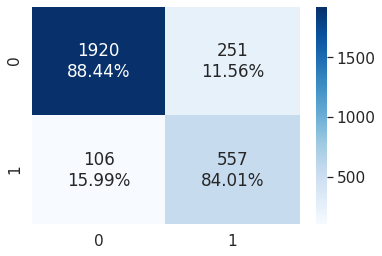

90.84%


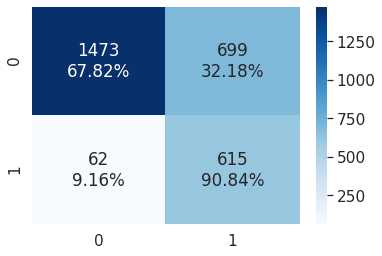

>>> RANDOM FLOREST 75 GINI : 86.5%



83.41%


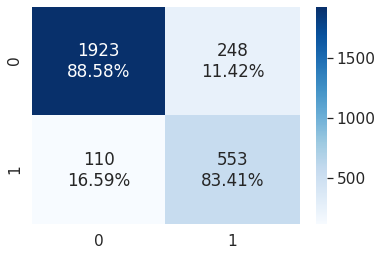

89.66%


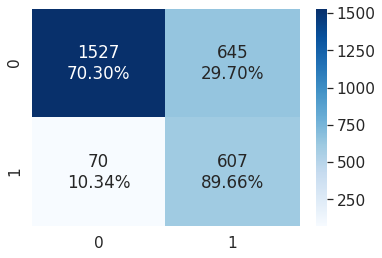

>>> RANDOM FLOREST 100 GINI : 87.4%



84.16%


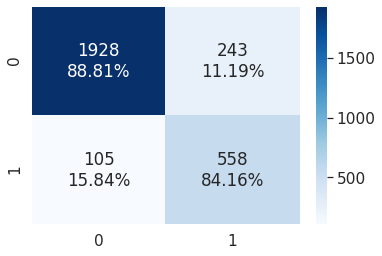

90.55%


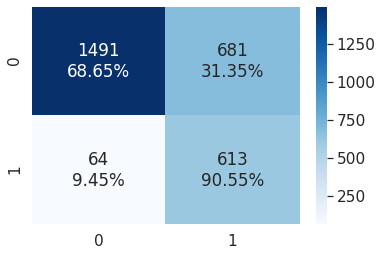

>>> RANDOM FLOREST 125 GINI : 86.8%



83.26%


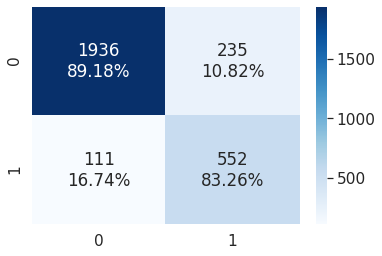

90.40%


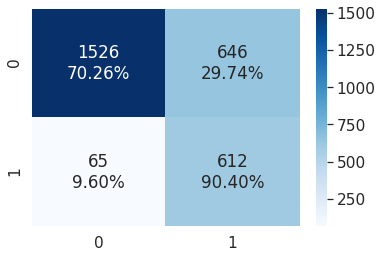

>>> RANDOM FLOREST 150 GINI : 86.2%



82.96%


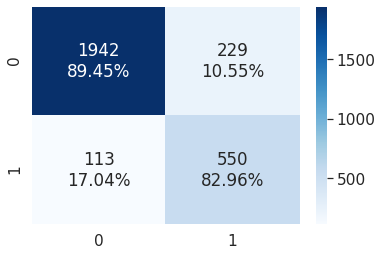

89.36%


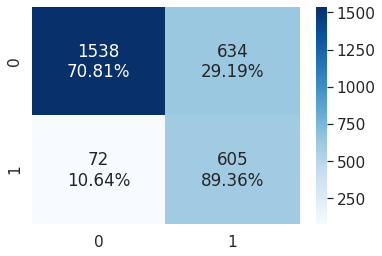

>>> RANDOM FLOREST 50 ENTROPY : 87.4%



84.62%


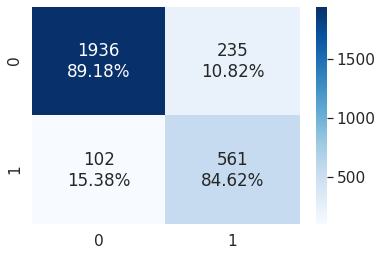

90.25%


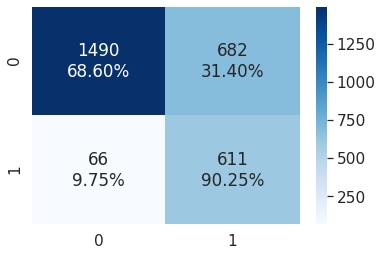

>>> RANDOM FLOREST 75 ENTROPY : 86.9%



84.01%


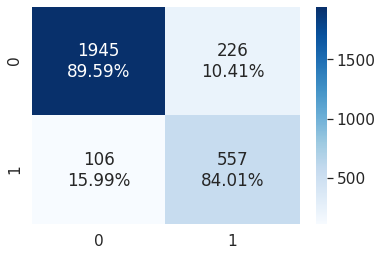

89.81%


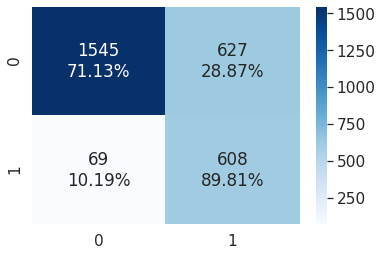

>>> RANDOM FLOREST 100 ENTROPY : 86.8%



83.71%


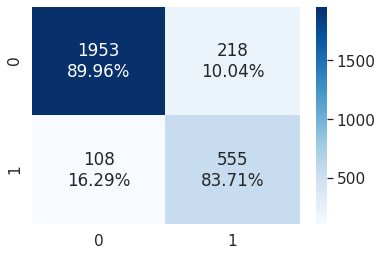

89.96%


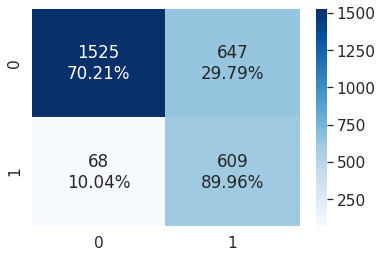

>>> RANDOM FLOREST 125 ENTROPY : 86.6%



83.41%


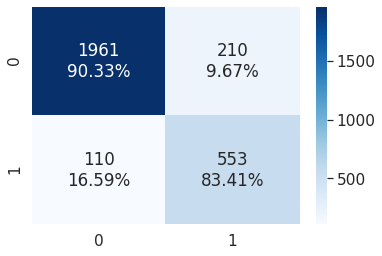

89.81%


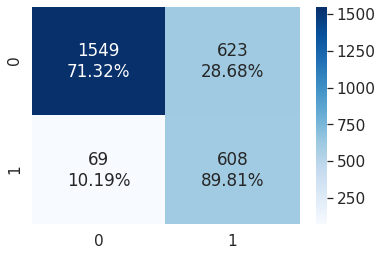

>>> RANDOM FLOREST 150 ENTROPY : 87.0%



83.71%


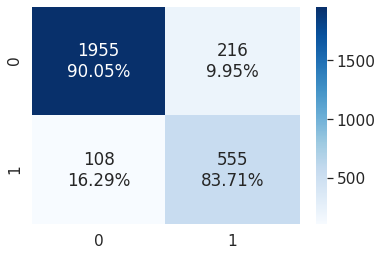

90.25%


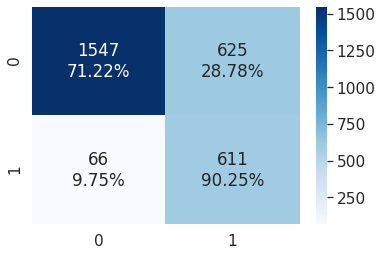

In [16]:
sns.set(font_scale=1.4)

recalls_by_classifiers = {}
statistics = []

for classifier in cms:
    statistic = {}

    mean_recall = np.mean([item['recall'] for item in cms[classifier]])
    recalls_by_classifiers[classifier] = mean_recall
    
    print(">>> {0} : {1:.1%}".format(classifier, mean_recall))
    print('\n\n')

    statistic['classifier'] = classifier
    statistic['recall'] = mean_recall*100
    

    for item in cms[classifier]:
        classifier_params = item['classifier'].get_params()
        print("{0:.2%}".format(item['recall']))

        statistic['n_estimators'] = classifier_params['n_estimators']
        statistic['criterion'] = classifier_params['criterion']

        group_counts = ["{0:0.0f}".format(value) for value in  item['cm'].flatten()]

        group_percentages = []
        f_item = item['cm'].flatten()
        for i in range(0, item['cm'].shape[0]):
            for y in range(0, item['cm'].shape[1]):
                group_percentages.append("{0:.2%}".format(item['cm'][i][y]/np.sum(item['cm'][i])))

        labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        statistics.append(statistic)
        
        sns.heatmap(item['cm'], annot=labels, fmt='', cmap='Blues')
        plt.show()


# Estatísticas das variações dos parâmetros dos classificadores

In [17]:
df_statistics = pd.DataFrame.from_records(data=statistics, exclude=['classifier'])
df_statistics.sort_values(by=['recall'], ascending=False)

,recall,n_estimators,criterion
10,87.433246,50,entropy
11,87.433246,50,entropy
1,87.427008,50,gini
0,87.427008,50,gini
4,87.354712,100,gini
5,87.354712,100,gini
18,86.980758,150,entropy
19,86.980758,150,entropy
12,86.910021,75,entropy
13,86.910021,75,entropy


# Salva o modelo em disco

In [18]:
better_classifier_by_recall = max(recalls_by_classifiers.items(), key=operator.itemgetter(1))
chosen_classifier = better_classifier_by_recall[0]

print(f'Better classifer: {chosen_classifier}')

modelname = os.path.join(output_config['file']['ref_dir'], output_config['file']['prefix'] + 'model.sav')
joblib.dump(cms[chosen_classifier][0]['classifier'], open(modelname, 'wb'))
 

Better classifer: RANDOM FLOREST 50 ENTROPY


# Carrega o modelo salvo

In [19]:
loaded_model = joblib.load(open(modelname, 'rb'))

# Testa com dados de validação

In [20]:
result = loaded_model.score(x_validation_chunk, y_validation_chunk)
print("{0:.2%}".format(result))

89.20%
